![](https://www.santander.co.uk/themes/custom/santander_web18/logo.svg)

[image-source](https://www.santander.co.uk/themes/custom/santander_web18/logo.svg)



## Main outline

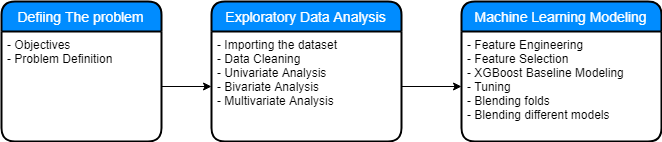

## Exploratory Data Analysis

![](http://blog.k2analytics.co.in/wp-content/uploads/2016/12/Exploratory_Data_Analysis.png)

[image-source](http://blog.k2analytics.co.in/wp-content/uploads/2016/12/Exploratory_Data_Analysis.png)

### Importing the dataset

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

import gc

# Any results you write to the current directory are saved as output.

In [ ]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

In [ ]:
train.shape, test.shape

In [ ]:
train.columns

At first glance we have many uncharacterized numerical features, their names has the prefix "var_" and they are 200 in numbers. There are so many variables that some histograms will shed light to their numerical appearance.

In [ ]:
train.target.value_counts()

In [ ]:
train['target'].value_counts().plot(kind="pie", figsize=(12,9), colormap="coolwarm")

Here we have a typical imbalanced dataset.

#### check for missing data

In [ ]:
train.isna().sum().sum()

In [ ]:
test.isna().sum().sum()

We have no NA values which is very nice!!

#### Splitting the numerical features

In [ ]:
train.describe()
gc.collect();

In [ ]:
numerical_features = train.columns[2:]

In [ ]:
print('Distributions columns')
plt.figure(figsize=(30, 185))
for i, col in enumerate(numerical_features):
    plt.subplot(50, 4, i + 1)
    plt.hist(train[col]) 
    plt.title(col)
gc.collect();

Almost all features shows a normal distribution shape. Lets see the distributions for for all numerical features per each class.

In [ ]:
print('Distributions columns')
plt.figure(figsize=(30, 185))
for i, col in enumerate(numerical_features):
    plt.subplot(50, 4, i + 1)
    plt.hist(train[train["target"] == 0][col], alpha=0.5, label='0', color='b')
    plt.hist(train[train["target"] == 1][col], alpha=0.5, label='1', color='r')    
    plt.title(col)
gc.collect();

In [ ]:
plt.figure(figsize=(20, 8))
train[numerical_features].mean().plot('hist');
plt.title('Mean Frequency');

In [ ]:
plt.figure(figsize=(20, 8))
train[numerical_features].median().plot('hist');
plt.title('Median Frequency');

In [ ]:
plt.figure(figsize=(20, 8))
train[numerical_features].std().plot('hist');
plt.title('Standard Deviation Frequency');

Most of the distributions show small std. deviations, and very few more than 20. Maybe a log transformation or a scaling technique to all features will alter the graph above to a normal one. 

In [ ]:
plt.figure(figsize=(20, 8))
train[numerical_features].skew().plot('hist');
plt.title('Skewness Frequency');

In [ ]:
plt.figure(figsize=(20, 8))
train[numerical_features].kurt().plot('hist');
plt.title('Kurtosis Frequency');

Both Skewness and Kurtosis show that the features distributions are like a normal one.

#### correlations between numerical data

In [ ]:
sns.set(rc={'figure.figsize':(20,28)})

# Compute the correlation matrix
corr = train[numerical_features].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, 
            #annot=True, 
            #fmt=".2f", 
            cmap='coolwarm')

the figure above shows that most of the pearson correlations between the numerical data are close to zero, in fact is between 0 and 0.2. That means that most of the numerical data are almost uncorrelated between them.

#### Most correlated features:

In [ ]:
s = corr.unstack().drop_duplicates()
so = s.sort_values(kind="quicksort")
so = so.drop_duplicates()

print("Top most highly positive correlated features:")
print(so[(so<1) & (so>0.5)].sort_values(ascending=False))

print()

print("Top most highly megative correlated features:")
print(so[(so < - 0.005)])

### EDA Summary

- We have 200 features that are mostly uncorrelated between them
- 200 numerical features that their histograms have a shape like the one of a normal distribution

## Machine Learning Modeling

![](https://cmci.colorado.edu/classes/INFO-4604/fa17/wordcloud.png)
[image-source](https://cmci.colorado.edu/classes/INFO-4604/fa17/wordcloud.png)

### Feature Engineering

In [ ]:
gc.collect();
for df in [test, train]:
    df['sum'] = df[numerical_features].sum(axis=1)  
    df['min'] = df[numerical_features].min(axis=1)
    df['max'] = df[numerical_features].max(axis=1)
    df['mean'] = df[numerical_features].mean(axis=1)
    df['std'] = df[numerical_features].std(axis=1)
    df['skew'] = df[numerical_features].skew(axis=1)
    df['kurt'] = df[numerical_features].kurtosis(axis=1)
    df['med'] = df[numerical_features].median(axis=1)

In [ ]:
y = train['target']
X = train.drop(['target', "ID_code"], axis=1)

In [ ]:
def xgboost_all_purpose(X, y, type_of_training):
    
    from sklearn.model_selection import train_test_split, StratifiedKFold
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import precision_score
    from sklearn.metrics import recall_score
    from sklearn.metrics import f1_score
    from sklearn.metrics import classification_report
    from sklearn.metrics import roc_auc_score
    import scikitplot as skplt
    import time
    import random
    
    import xgboost as xgb
    
    # xgboost parameters
    eta = 0.03
    estimators  = 8000
    depth = 6
    gamma_value = 0
    colsample_bytree_value = 1
    max_rounds = 400
    child_weight = 1
    
    if type_of_training == "baseline":
    # create a 70/30 split of the data 
        xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, random_state=42, test_size=0.3)
    
        import xgboost as xgb

        start_time = time.time()

        clf_xgb = xgb.XGBClassifier(learning_rate=eta, 
                                    n_estimators=estimators, 
                                    max_depth=depth,
                                    min_child_weight=child_weight,
                                    gamma=gamma_value,
                                    subsample=1,
                                    colsample_bytree=colsample_bytree_value,
                                    objective= 'binary:logistic',
                                    nthread=-1,
                                    scale_pos_weight=1,
                                    reg_alpha = 0,
                                    reg_lambda = 1,
                                    seed=42)

        clf_xgb.fit(xtrain, ytrain, eval_set=[(xtrain, ytrain), (xvalid, yvalid)], 
                    early_stopping_rounds=max_rounds, eval_metric='auc', verbose=100)

        predictions = clf_xgb.predict(xvalid)
        predictions_probas = clf_xgb.predict_proba(xvalid)

        print()
        print(classification_report(yvalid, predictions))

        print()
        print("f1_score", f1_score(yvalid, predictions, average = "macro"))

        print()
        print("elapsed time in seconds: ", time.time() - start_time)
        
        sns.set(rc={'figure.figsize':(8, 8)})
        skplt.metrics.plot_confusion_matrix(yvalid, predictions, normalize=True)
        
        predictions_probas = clf_xgb.predict_proba(xvalid)
        skplt.metrics.plot_roc(yvalid, predictions_probas)
        
        skplt.metrics.plot_precision_recall(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(12, 38)})
        xgb.plot_importance(clf_xgb, title='Feature importance', xlabel='F score', ylabel='Features')

        print()
        gc.collect();
        return clf_xgb
        
    elif type_of_training == "stratified":
        
        xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, random_state=42, test_size=0.3)
        
        predictions_probas_list = []
        index_fold = 0
        best_score = 1
        
        folds = StratifiedKFold(n_splits=3, shuffle=True, random_state = 42)
        
        clf_stra_xgb = xgb.XGBClassifier(learning_rate=eta, 
                                    n_estimators=estimators, 
                                    max_depth=depth,
                                    min_child_weight=child_weight,
                                    gamma=gamma_value,
                                    subsample=1,
                                    colsample_bytree=colsample_bytree_value,
                                    objective= 'binary:logistic',
                                    nthread=-1,
                                    scale_pos_weight=1,
                                    reg_alpha = 0,
                                    reg_lambda = 1,
                                    seed=42)
        
        for train_index, valid_index in folds.split(xtrain, ytrain):
            xtrain_stra, xvalid_stra = xtrain.iloc[train_index,:], xtrain.iloc[valid_index,:]
            ytrain_stra, yvalid_stra = ytrain.iloc[train_index], ytrain.iloc[valid_index]

            print("Stratified Fold:", index_fold)
            index_fold = index_fold + 1
            
            import xgboost as xgb

            start_time = time.time()


            clf_stra_xgb.fit(xtrain_stra, ytrain_stra, eval_set=[(xtrain_stra, ytrain_stra), (xvalid_stra, yvalid_stra)], 
                        early_stopping_rounds=max_rounds, eval_metric='auc', verbose=100)
            
            #if (clf_stra_xgb.best_score < best_score):
            #    clf_best_stra_xgb = clf_stra_xgb
            #    best_score = clf_stra_xgb.best_score
            
            print()

            predictions_probas = clf_stra_xgb.predict_proba(xvalid)
            predictions_probas_list.append(predictions_probas)
            
        
        predictions_probas=[sum(i)/index_fold for i in zip(*predictions_probas_list)]
        predictions = np.argmax(predictions_probas, axis=1)
        
        #xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, random_state=42, test_size=0.3)
        #clf_stra_xgb = clf_best_stra_xgb
        #del clf_best_stra_xgb
        #print("Best score:", best_score)
        
        predictions = clf_stra_xgb.predict(xvalid)
        predictions_probas = clf_stra_xgb.predict_proba(xvalid)

        print()
        print(classification_report(yvalid, predictions))

        print()
        print("f1_score", f1_score(yvalid, predictions, average = "macro"))

        print()
        print("elapsed time in seconds: ", time.time() - start_time)
        
        sns.set(rc={'figure.figsize':(8, 8)})
        skplt.metrics.plot_confusion_matrix(yvalid, predictions, normalize=True)
        
        skplt.metrics.plot_roc(yvalid, predictions_probas)
        
        skplt.metrics.plot_precision_recall(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(12, 38)})
        xgb.plot_importance(clf_stra_xgb, title='Feature importance', xlabel='F score', ylabel='Features')

        print()
        gc.collect();
        return clf_stra_xgb

    elif type_of_training == "oversampling":
        
        #### resampling techniques:
        from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler

        # create a 70/30 split of the data 
        xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, random_state=42, test_size=0.3)

        # RandomOverSampler
        ros = RandomOverSampler(random_state=42)
        X_resampled, y_resampled = ros.fit_resample(xtrain, ytrain)
        xtrain=pd.DataFrame(X_resampled, columns = X.columns)
        ytrain = y_resampled
        

        start_time = time.time()

        clf_ros_xgb = xgb.XGBClassifier(learning_rate=eta, 
                                    n_estimators=estimators, 
                                    max_depth=depth,
                                    min_child_weight=child_weight,
                                    gamma=gamma_value,
                                    subsample=1,
                                    colsample_bytree=colsample_bytree_value,
                                    objective= 'binary:logistic',
                                    nthread=-1,
                                    scale_pos_weight=1,
                                    reg_alpha = 0,
                                    reg_lambda = 1,
                                    seed=42)

        clf_ros_xgb.fit(xtrain, ytrain, eval_set=[(xtrain, ytrain), (xvalid, yvalid)], 
                    early_stopping_rounds=max_rounds, eval_metric='auc', verbose=100)

        predictions = clf_ros_xgb.predict(xvalid)
        predictions_probas = clf_ros_xgb.predict_proba(xvalid)

        print()
        print(classification_report(yvalid, predictions))

        print()
        print("f1_score", f1_score(yvalid, predictions, average = "macro"))

        print()
        print("elapsed time in seconds: ", time.time() - start_time)
        
        sns.set(rc={'figure.figsize':(8, 8)})
        skplt.metrics.plot_confusion_matrix(yvalid, predictions, normalize=True)
        
        skplt.metrics.plot_roc(yvalid, predictions_probas)
        
        skplt.metrics.plot_precision_recall(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(12, 38)})
        xgb.plot_importance(clf_ros_xgb, title='Feature importance', xlabel='F score', ylabel='Features')

        print()
        gc.collect();
        return clf_ros_xgb
    
    elif type_of_training == "smote":
        #### resampling techniques:
        from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler

        # create a 70/30 split of the data 
        xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, random_state=42, test_size=0.3)

        # SMOTE
        smote = SMOTE(random_state=42)
        X_resampled, y_resampled = smote.fit_resample(xtrain, ytrain)
        xtrain=pd.DataFrame(X_resampled, columns = X.columns)
        ytrain = y_resampled

        start_time = time.time()

        clf_smote_xgb = xgb.XGBClassifier(learning_rate=eta, 
                                    n_estimators=estimators, 
                                    max_depth=depth,
                                    min_child_weight=child_weight,
                                    gamma=gamma_value,
                                    subsample=1,
                                    colsample_bytree=colsample_bytree_value,
                                    objective= 'binary:logistic',
                                    nthread=-1,
                                    scale_pos_weight=1,
                                    reg_alpha = 0,
                                    reg_lambda = 1,
                                    seed=42)

        clf_smote_xgb.fit(xtrain, ytrain, eval_set=[(xtrain, ytrain), (xvalid, yvalid)], 
                    early_stopping_rounds=max_rounds, eval_metric='auc', verbose=100)

        predictions = clf_smote_xgb.predict(xvalid)
        predictions_probas = clf_smote_xgb.predict_proba(xvalid)

        print()
        print(classification_report(yvalid, predictions))

        print()
        print("f1_score", f1_score(yvalid, predictions, average = "macro"))

        print()
        print("elapsed time in seconds: ", time.time() - start_time)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_confusion_matrix(yvalid, predictions, normalize=True)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_roc(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_ks_statistic(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_precision_recall(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_cumulative_gain(yvalid, predictions_probas)

        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_lift_curve(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(12, 38)})
        xgb.plot_importance(clf_smote_xgb, title='Feature importance', xlabel='F score', ylabel='Features')

        print()
        gc.collect();
        return clf_smote_xgb
    
    elif type_of_training == "undersampling":
        
        #### resampling techniques:
        from imblearn.under_sampling import RandomUnderSampler

        # create a 70/30 split of the data 
        xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, random_state=42, test_size=0.3)

        # RandomUnderSampler
        rus = RandomUnderSampler(random_state=42)
        X_resampled, y_resampled = rus.fit_resample(xtrain, ytrain)
        xtrain=pd.DataFrame(X_resampled, columns = X.columns)
        ytrain = y_resampled

        start_time = time.time()

        clf_rus_xgb = xgb.XGBClassifier(learning_rate=eta, 
                                    n_estimators=estimators, 
                                    max_depth=depth,
                                    min_child_weight=child_weight,
                                    gamma=gamma_value,
                                    subsample=1,
                                    colsample_bytree=colsample_bytree_value,
                                    objective= 'binary:logistic',
                                    nthread=-1,
                                    scale_pos_weight=1,
                                    reg_alpha = 0,
                                    reg_lambda = 1,
                                    seed=42)

        clf_rus_xgb.fit(xtrain, ytrain, eval_set=[(xtrain, ytrain), (xvalid, yvalid)], 
                    early_stopping_rounds=max_rounds, eval_metric='auc', verbose=100)

        predictions = clf_rus_xgb.predict(xvalid)
        predictions_probas = clf_rus_xgb.predict_proba(xvalid)

        print()
        print(classification_report(yvalid, predictions))

        print()
        print("f1_score", f1_score(yvalid, predictions, average = "macro"))

        print()
        print("elapsed time in seconds: ", time.time() - start_time)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_confusion_matrix(yvalid, predictions, normalize=True)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_roc(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_ks_statistic(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_precision_recall(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_cumulative_gain(yvalid, predictions_probas)

        sns.set(rc={'figure.figsize':(8,8)})
        skplt.metrics.plot_lift_curve(yvalid, predictions_probas)
        
        sns.set(rc={'figure.figsize':(12, 38)})
        xgb.plot_importance(clf_rus_xgb, title='Feature importance', xlabel='F score', ylabel='Features')

        print()
        gc.collect();
        #return clf_rus_xgb, predictions, predictions_probas
        return clf_rus_xgb
    
    else:
        print("Please specify for the argument 'type_of_training'one of the following parameters: (baseline, stratified, oversampling, smote, undersampling, tomek)")

In [ ]:
clf_xgb = xgboost_all_purpose(X,y, type_of_training ="baseline")

In [ ]:
rus_clf_xgb = xgboost_all_purpose(X,y, type_of_training ="undersampling")

In [ ]:
### code for testing
'''
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
import time

# create a 70/30 split of the data 
xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, stratify = y, random_state=42, test_size=0.3)

import xgboost as xgb

start_time = time.time()

clf_xgb = xgb.XGBClassifier(learning_rate=0.05, 
                            n_estimators=3000, 
                            max_depth=6,
                            min_child_weight=1,
                            gamma=0,
                            subsample=1,
                            colsample_bytree=1,
                            objective= 'binary:logistic',
                            nthread=-1,
                            scale_pos_weight=1,
                            reg_alpha = 0,
                            reg_lambda = 1,
                            seed=42)

clf_xgb.fit(xtrain, ytrain, eval_set=[(xtrain, ytrain), (xvalid, yvalid)], 
            early_stopping_rounds=100, eval_metric='auc', verbose=100)

predictions = clf_xgb.predict(xvalid)

print()
print(classification_report(yvalid, predictions))

print()
print("accuracy_score", accuracy_score(yvalid, predictions))

print()
predictions_probas = clf_xgb.predict_proba(xvalid)
print("roc-auc score", roc_auc_score(yvalid, predictions_probas[:,1]))

print()
print("elapsed time in seconds: ", time.time() - start_time)

print()
gc.collect()
'''

### Feature Selection - Permutation Importance

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=42)
rfc_model = RandomForestClassifier(random_state=42).fit(train_X, train_y)

import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rfc_model, random_state=42).fit(val_X, val_y)

In [ ]:
eli5.show_weights(perm, feature_names = val_X.columns.tolist(), top=100)

#### Select top 100 features after permutation importance:

In [ ]:
from sklearn.feature_selection import SelectFromModel

max_selected_features = 100
sel = SelectFromModel(perm, max_features = max_selected_features, prefit=True)
X_trans = sel.transform(X)

feature_idx = sel.get_support()
feature_name = X.columns[feature_idx]

X_trans = X[feature_name]
X_trans.shape

### XGBoost Training after Feature Selection

In [ ]:
trans_clf_xgb = xgboost_all_purpose(X_trans,y, type_of_training ="baseline")

In [ ]:
rus_trans_clf_xgb = xgboost_all_purpose(X_trans,y, type_of_training ="undersampling")

## ML Blends
** To be updated **

## Preparing for submmission

In [ ]:
gc.collect();
submission = pd.read_csv('../input/sample_submission.csv')
submission['target'] = clf_xgb.predict(test.drop("ID_code", axis="columns"))
submission.to_csv('xgboost.csv', index=False)

gc.collect();
submission = pd.read_csv('../input/sample_submission.csv')
submission['target'] = clf_rus_xgb.predict(test.drop("ID_code", axis="columns"))
submission.to_csv('xgboost_rus.csv', index=False)


gc.collect();
submission = pd.read_csv('../input/sample_submission.csv')
submission['target'] = trans_clf_xgb.predict(test.drop("ID_code", axis="columns"))
submission.to_csv('xgboost_trans.csv', index=False)

gc.collect();
submission = pd.read_csv('../input/sample_submission.csv')
submission['target'] = rus_trans_clf_xgb.predict(test.drop("ID_code", axis="columns"))
submission.to_csv('xgboost_trans_xgb.csv', index=False)

## Conclusion
We can see from EDA and ML Modeling that class #1 is very unbalanced and difficult to identified and classified.